# Module 03

## Session 08 Ensemble Methods

* Data: adult.csv
    - target: income
    - feature: preprocess
        - missing value: simple imputer with constant
        - one hot encoding: relationship, race, sex
        - binary encoding: workclass, martial status, occupation, native country
        - ordinal encoding: education (already encoded)
        - no treatment: numerical
        - out: fnlwgt
* Random state 10 
* data splitting 70:30
* stratify
* model:
    - tree: model tree(max depth 3) and compute precsiion, recall, f1 test set then compute the feature importances and show the tree
    - adaboost: tree adaptive boosting (max depth 3, n_estimator(B) 200, learning rate 0.1) and compute precsiion, recall, f1 test set then compute the feature importances
    - gbc: gradient boosting (max depth 3, n_estimator(B) 200, learning rate 0.1) and compute precsiion, recall, f1 test set then compute the feature importances
    - xgb: extreme gradient boosting (max depth 3, n_estimator(B) 200, learning rate 0.1) and compute precsiion, recall, f1 test set then compute the feature importances
    - model selection using grid search (tree, tree adaboost, gbc, xgb) optimized by f1 and using stratified CV 5 fold
    - hyperparameter tuning the winner (optimize B, L, and max depth) ptimized by f1 and using stratified CV 5 fold
    - Evaluate the tuned model in test set using precision, recall, f1 score, ROC, PRC. Compare the result

# Library

In [2]:
!pip install category_encoders

     |████████████████████████████████| 80 kB 4.8 MB/s 


In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, plot_roc_curve, plot_precision_recall_curve

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data

In [6]:
df_adult = pd.read_csv('adult.csv')
df_adult.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [7]:
df_adult.replace("?", np.nan, inplace=True)

In [8]:
df_adult.isnull().sum()

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

# Preprocessing Scenario

In [9]:
onehot = OneHotEncoder()
onehot_var = ['relationship', 'race', 'gender']

binary = ce.BinaryEncoder()
imputer = SimpleImputer(strategy='constant', fill_value='NC')
binary_pipe = Pipeline(
    [
        ('imputer', imputer),
        ('encoder', binary)
    ]
)
binary_var = ['workclass', 'marital-status', 'occupation', 'native-country']

transformer = ColumnTransformer(
    [
        ('onehot', onehot, onehot_var),
        ('binary', binary_pipe, binary_var),
    ],
    remainder='passthrough'
)

# Data Splitting

In [10]:
X = df_adult.drop(columns=['fnlwgt', 'income', 'education'])
y = np.where(df_adult['income'] == '>50K',1,0)

In [11]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.3,
    random_state=10
)

# Data Transformation

In [12]:
X_trainval_prep = transformer.fit_transform(X_trainval)
X_test_prep = transformer.fit_transform(X_test)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [13]:
X_trainval_prep = pd.DataFrame(X_trainval_prep)
X_test_prep = pd.DataFrame(X_test_prep)


In [14]:
onehot_features = list(transformer.transformers_[0][1].get_feature_names())
binary_features = list(transformer.transformers_[1][1]['encoder'].get_feature_names())
features = onehot_features + binary_features + ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [15]:
X_trainval_prep.columns = features
X_test_prep.columns = features

# Modeling

## Modeling result function

In [16]:
def modeling_result(models):
    models.fit(X_trainval_prep, y_trainval)

    y_pred = models.predict(X_test_prep)
    print(classification_report(y_test, y_pred))

    fi = models.feature_importances_

    imp_table = pd.DataFrame(
        {
            'imp':fi
        },
        index=features
    )

    imp_table.sort_values(by='imp').plot(kind='barh', figsize=(12,12))

## 1. TREE

In [17]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_trainval_prep, y_trainval)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

              precision    recall  f1-score   support

           0       0.85      0.96      0.90     11147
           1       0.77      0.48      0.59      3506

    accuracy                           0.84     14653
   macro avg       0.81      0.72      0.75     14653
weighted avg       0.83      0.84      0.83     14653



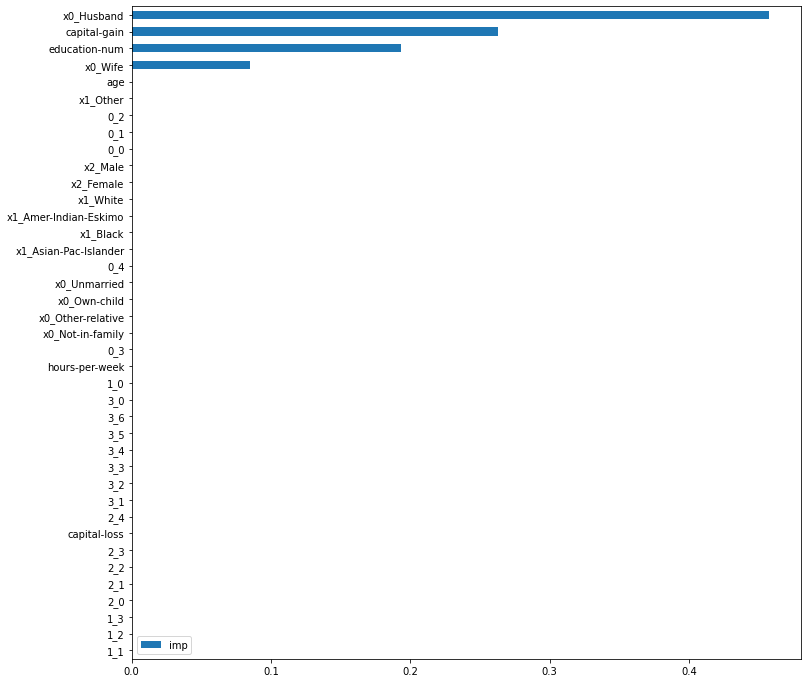

In [18]:
modeling_result(tree)

## 2. Adaptive Boosting

In [19]:
tree = DecisionTreeClassifier(max_depth=3)
tree_ada = AdaBoostClassifier(
    tree,
    n_estimators=200,
    learning_rate=0.1,
    random_state=10
)

              precision    recall  f1-score   support

           0       0.88      0.95      0.92     11147
           1       0.79      0.60      0.69      3506

    accuracy                           0.87     14653
   macro avg       0.84      0.78      0.80     14653
weighted avg       0.86      0.87      0.86     14653



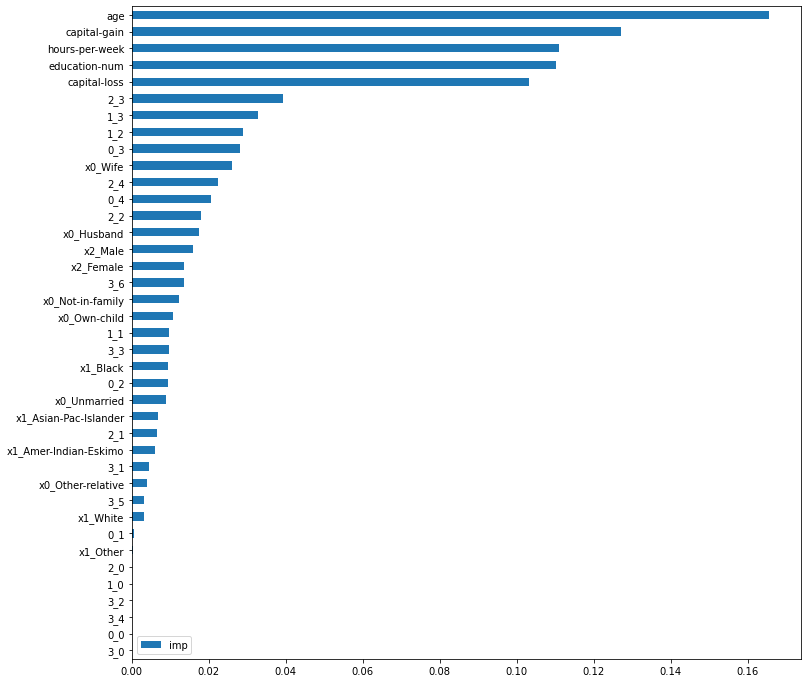

In [20]:
modeling_result(tree_ada)

## 3. Gradient Boosting

In [21]:
model_gbc = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=10
)

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     11147
           1       0.78      0.60      0.68      3506

    accuracy                           0.86     14653
   macro avg       0.83      0.77      0.80     14653
weighted avg       0.86      0.86      0.86     14653



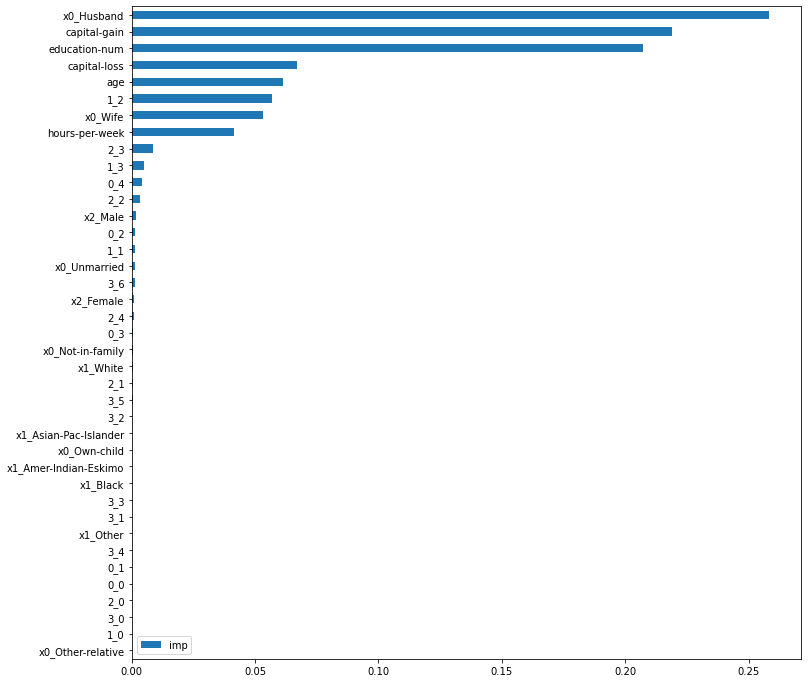

In [22]:
modeling_result(model_gbc)

## 4. XGB

In [23]:
model_xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=10
)

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     11147
           1       0.79      0.59      0.67      3506

    accuracy                           0.86     14653
   macro avg       0.83      0.77      0.79     14653
weighted avg       0.86      0.86      0.86     14653



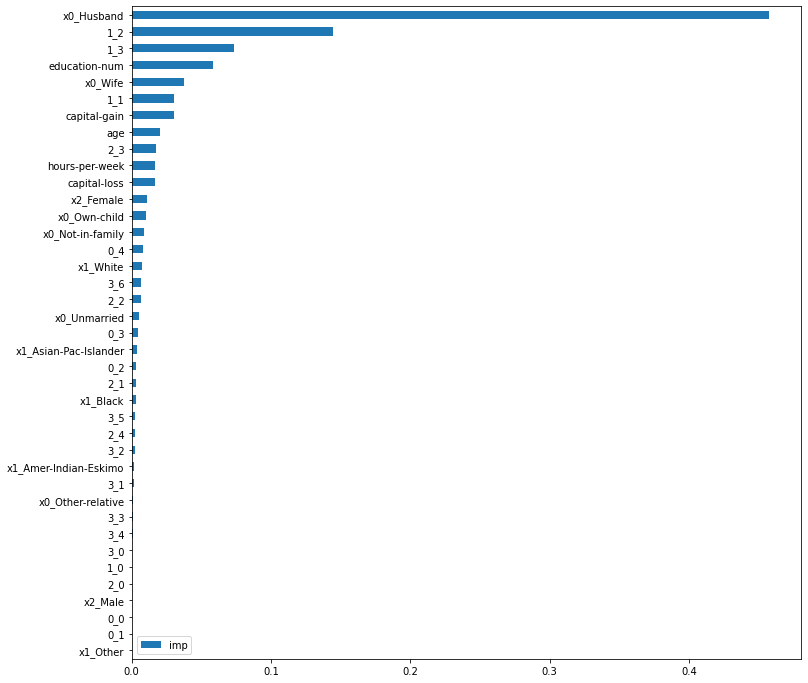

In [24]:
modeling_result(model_xgb)

# Model Selection

In [26]:
tree = DecisionTreeClassifier(max_depth=3)

tree_ada = AdaBoostClassifier(
    tree,
    n_estimators=200,
    learning_rate=0.1,
    random_state=10
)

model_gbc = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=10
)

model_xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=10
)

estimator = Pipeline(
    [
        ('preprocess', transformer),
        ('clf', tree)
    ]
)

skfold = StratifiedKFold(n_splits=5)

hyperparam_space = {
    'clf':[tree, tree_ada, model_gbc, model_xgb]
}

grid_model = GridSearchCV(
    estimator,
    param_grid=hyperparam_space,
    cv=skfold,
    scoring='f1',
    n_jobs=-1
)

In [27]:
grid_model.fit(X_trainval, y_trainval)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocess',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(categories='auto',
                                                                                       drop=None,
                                                                                       dtype=<class 'numpy.float64'>,
                                                                     

In [28]:
print(grid_model.best_score_)
print(grid_model.best_params_)

0.697877019207275
{'clf': AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',


In [30]:
pd.DataFrame(grid_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.294374,0.023885,0.056163,0.007752,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'clf': DecisionTreeClassifier(ccp_alpha=0.0, ...",0.581159,0.578469,0.587170,0.591252,0.595085,0.586627,0.006159,4
1,14.167505,0.130111,0.493746,0.007660,"AdaBoostClassifier(algorithm='SAMME.R',\n ...",{'clf': AdaBoostClassifier(algorithm='SAMME.R'...,0.697485,0.695444,0.697154,0.701157,0.698145,0.697877,0.001867,1
2,11.875985,0.143466,0.079062,0.004153,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",{'clf': GradientBoostingClassifier(ccp_alpha=0...,0.695978,0.690083,0.694311,0.700172,0.695682,0.695245,0.003241,2
3,7.902746,0.938350,0.088035,0.011505,"XGBClassifier(base_score=0.5, booster='gbtree'...","{'clf': XGBClassifier(base_score=0.5, booster=...",0.692757,0.686911,0.696038,0.698347,0.693488,0.693508,0.003845,3


# Final Model

In [32]:
tree = DecisionTreeClassifier(max_depth=3)
tree_ada = AdaBoostClassifier(
    tree,
    n_estimators=200,
    learning_rate=0.1,
    random_state=10
)

estimator = Pipeline(
    [
        ('preprocess', transformer),
        ('clf', tree_ada)
    ]
)

skfold = StratifiedKFold(n_splits=5)

hyperparam_space = {
    'clf__learning_rate':[0.1, 0.05, 0.2],
    'clf__n_estimators':[200,300,400],
    'clf__base_estimator__max_depth':[2,3,5]
}

tune_ada = GridSearchCV(
    estimator,
    param_grid=hyperparam_space,
    cv=skfold,
    scoring='f1',
    n_jobs=-1
)

In [ ]:
print(estimator.get_params().keys())

In [34]:
tune_ada.fit(X_trainval, y_trainval)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocess',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(categories='auto',
                                                                                       drop=None,
                                                                                       dtype=<class 'numpy.float64'>,
                                                                     

In [35]:
print(tune_ada.best_score_)
print(tune_ada.best_params_)

0.7047423693646635
{'clf__base_estimator__max_depth': 3, 'clf__learning_rate': 0.2, 'clf__n_estimators': 400}


# Comparison

In [36]:
best_model = tune_ada.best_estimator_
best_model.fit(X_trainval, y_trainval)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehot',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['relationship', 'race',
                                                   'gender']),
                                                 ('binary',
                                                  Pipeline(memory=None,
       

In [37]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     11147
           1       0.78      0.66      0.72      3506

    accuracy                           0.87     14653
   macro avg       0.84      0.80      0.82     14653
weighted avg       0.87      0.87      0.87     14653



              precision    recall  f1-score   support

           0       0.88      0.95      0.92     11147
           1       0.79      0.60      0.69      3506

    accuracy                           0.87     14653
   macro avg       0.84      0.78      0.80     14653
weighted avg       0.86      0.87      0.86     14653



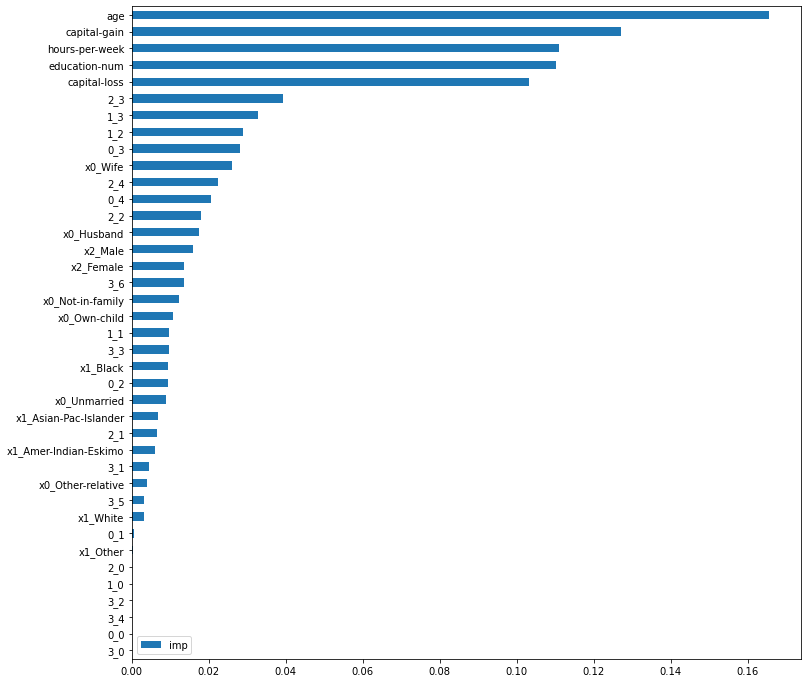

In [38]:
modeling_result(tree_ada)